# Why measuring inequality with the Gini index is a bad idea

This is a notebook containing the code for the [post](https://lexparsimon.github.io/Gini/) on the drawbacks of the Gini index for measuring heterogeneity of socio-economic values in urban environments and the alternative measures to to complement the Gini in urban analysis.

In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

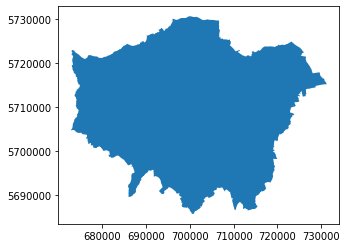

time: 207 ms


In [4]:
#load data
parking_demand = np.loadtxt('data/parking_demand.txt')
london = gpd.read_file('data/london.shp')
london.plot()

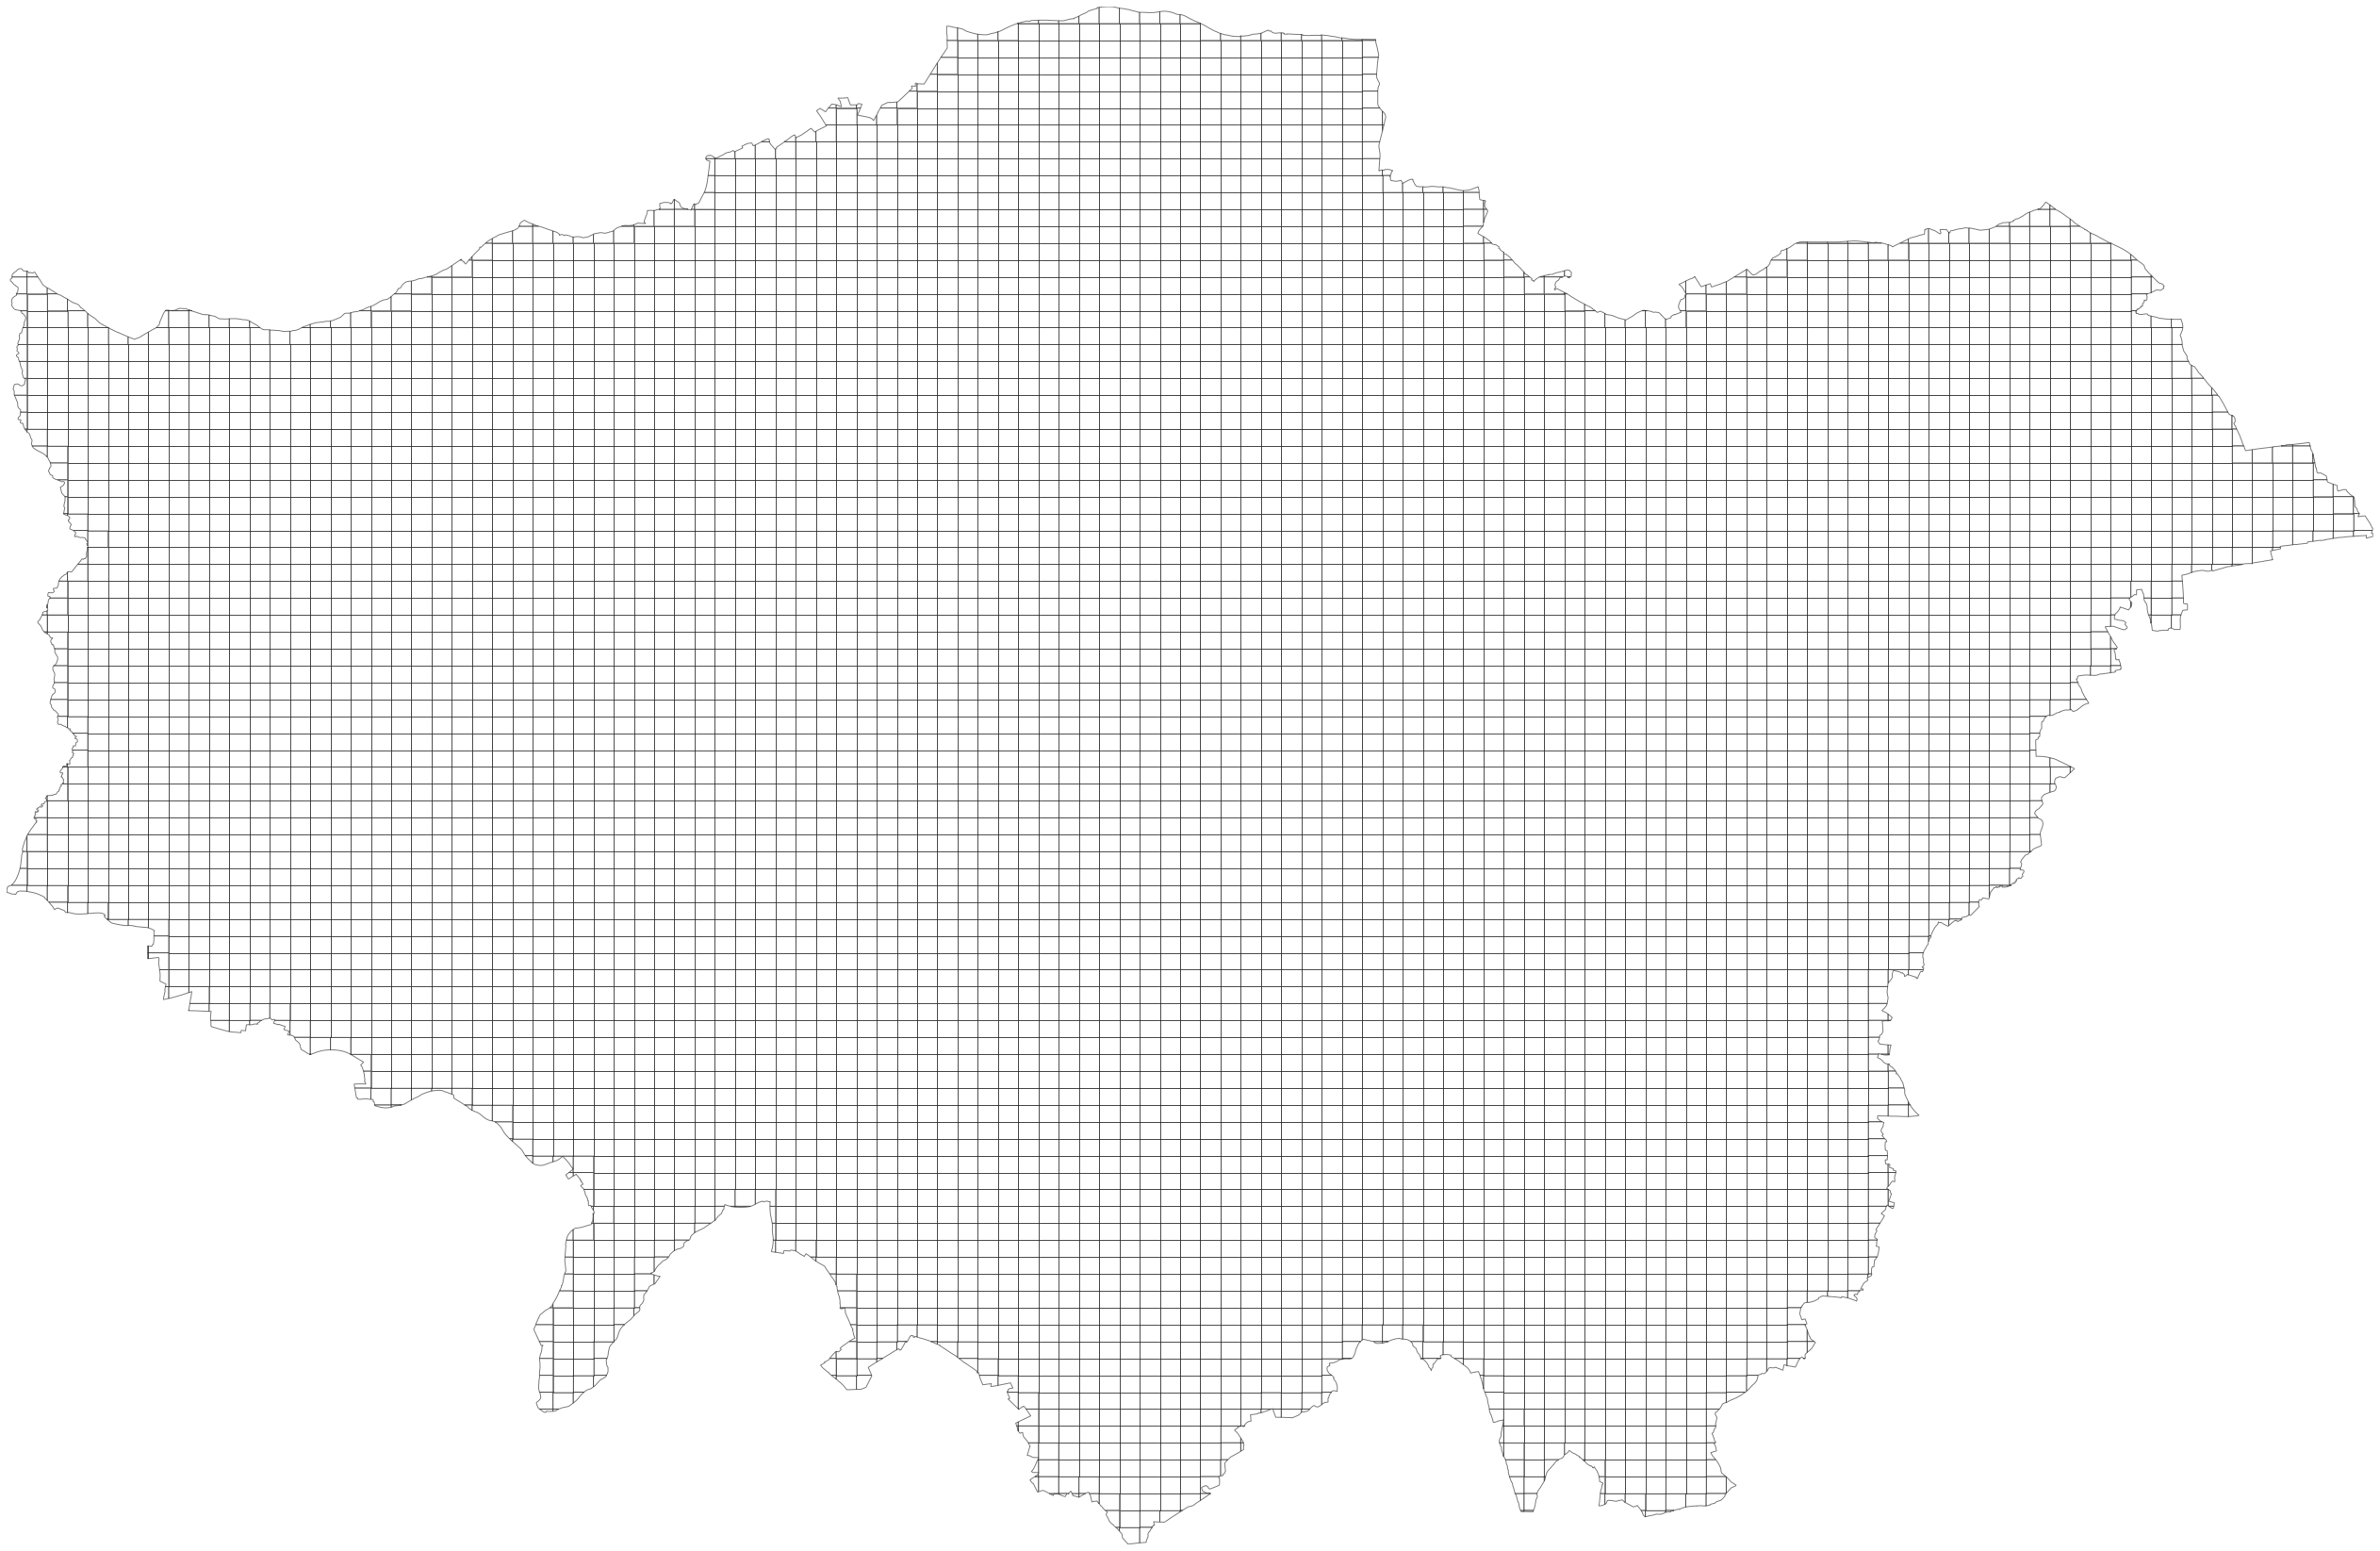

time: 17.8 s


In [5]:
#subdivide city into 500x500m grid 

# make the geometry a multipolygon if it's not already
geometry = london['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=500)

polylist = [p for p in geometry_cut]
# plot the city
west, south, east, north = london.unary_union.bounds
fig, ax = plt.subplots(figsize=(45,30))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=10)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [6]:
#make geodataframe
polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = london.geometry.crs
polyframe.tail()

,geometry
6786,"POLYGON ((694334.745 5710913.886, 694832.758 5..."
6787,"POLYGON ((694334.745 5710418.367, 694832.758 5..."
6788,"POLYGON ((694334.745 5709922.848, 694832.758 5..."
6789,"POLYGON ((694334.745 5709427.329, 694832.758 5..."
6790,"POLYGON ((694334.745 5708931.810, 694832.758 5..."


time: 25 ms


In [7]:
polyflows = polyframe.copy()
polyflows['inflow'] = parking_demand
polyflows.head()

,geometry,inflow
0,"POLYGON ((672920.208 5704819.744, 672921.309 5...",3905.0
1,"POLYGON ((673032.208 5704967.658, 673036.875 5...",5949.0
2,"POLYGON ((673245.155 5705463.177, 673248.498 5...",7743.0
3,"POLYGON ((673309.990 5705958.696, 673310.283 5...",7002.0
4,"POLYGON ((673418.220 5706414.124, 673427.828 5...",2941.0


time: 13 ms


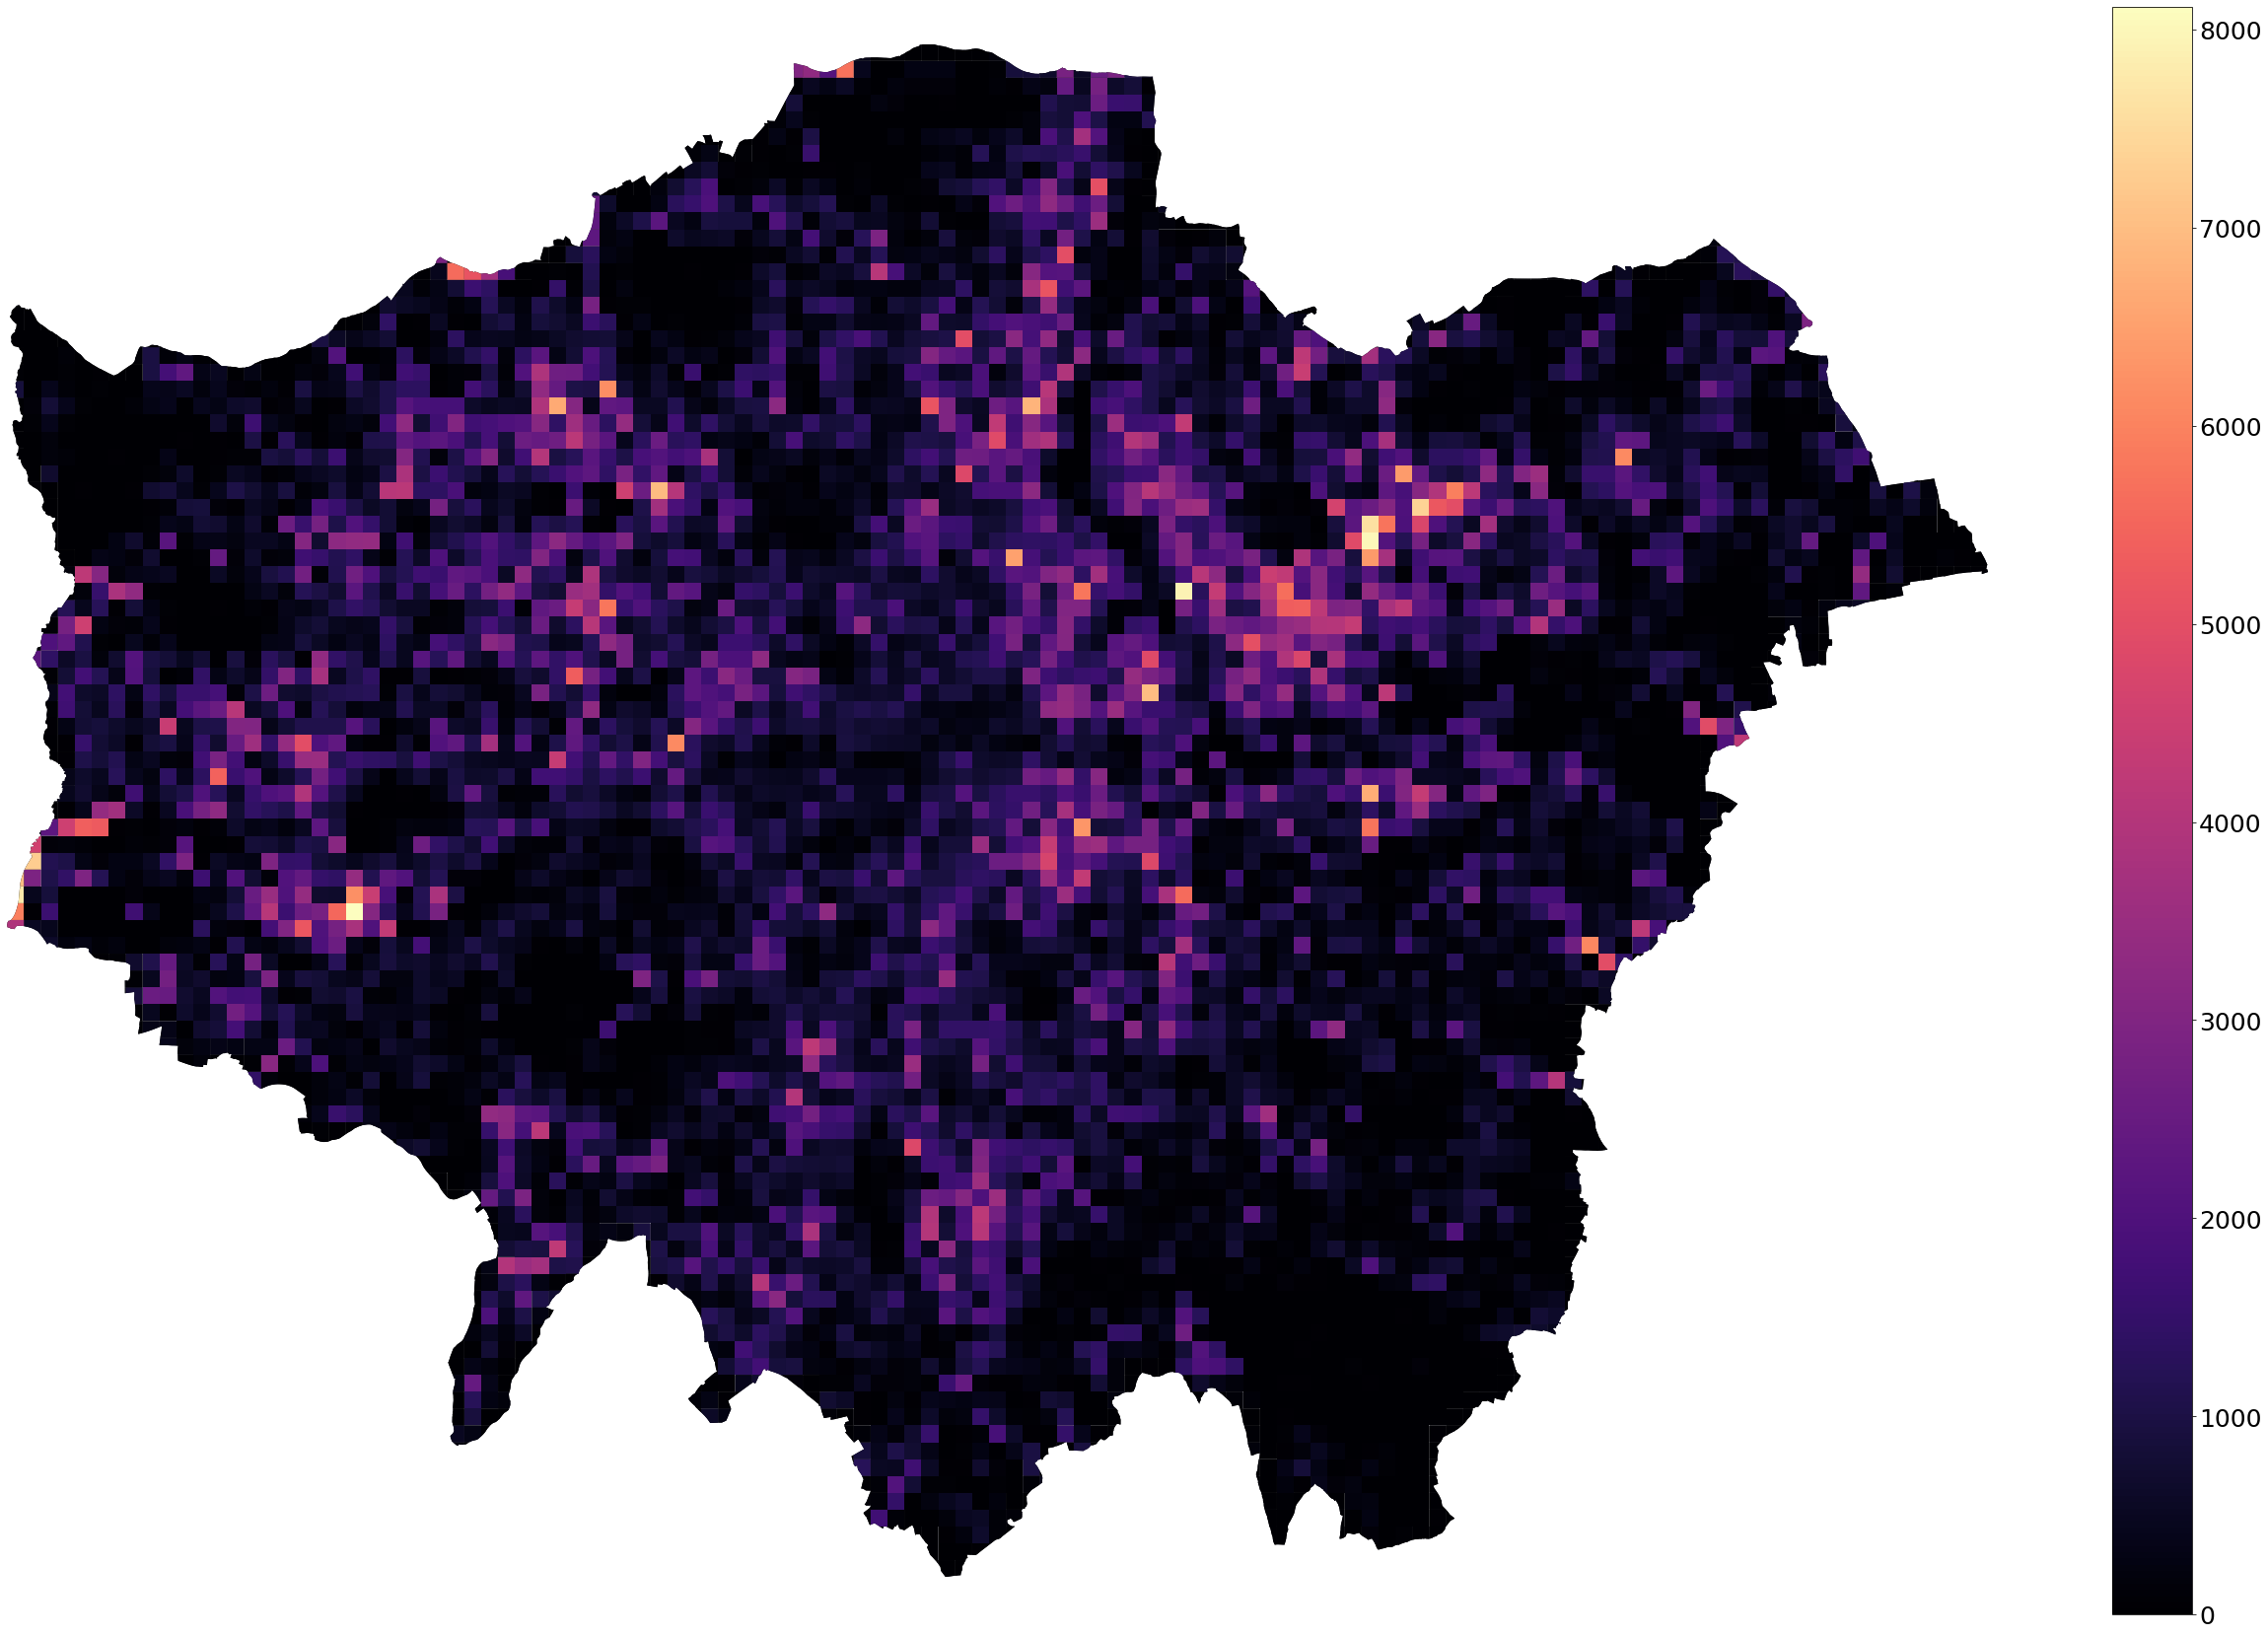

time: 3.61 s


In [8]:
# plot the parking demand in London
plt.rcParams.update({'font.size': 25})
west, south, east, north = london.unary_union.bounds
fig, ax = plt.subplots(figsize=(45,30))
polyframe.plot(ax=ax, color='#000004')
polyflows.plot(column='inflow',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

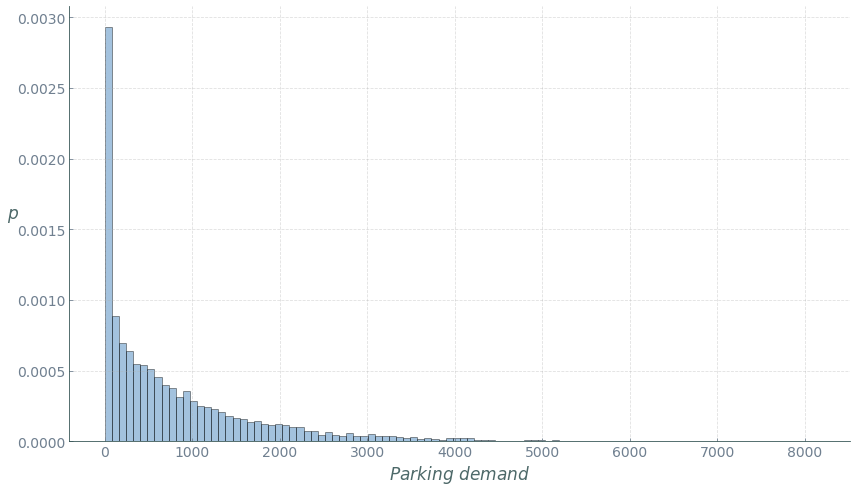

time: 364 ms


In [11]:
#plot parking demand histogram
cmap = plt.cm.get_cmap('Blues')
y = np.array(polyflows.inflow)
fig, ax = plt.subplots(figsize=(14,8))
ax.patch.set_alpha(0.55)
ax.grid(alpha=0.4, ls='--')
plt.hist(y, 100, density=True, alpha=0.4, align='mid',histtype='bar',
                                ec='black', color=cmap(200))

ax.tick_params(direction="in", labelsize=14)
#ax.set_xlim(-100,taxi_nums[-1])
#ax.set_ylim(0,1)
ax.set_xlabel(r'$Parking \ demand$', fontsize= 17, alpha=0.85, color='darkslategrey')
ax.set_ylabel(r'$p$', fontsize= 17, alpha=0.85, color='darkslategrey', rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_color('darkslategrey')
ax.spines['top'].set_color('darkslategrey') 
ax.spines['right'].set_color('darkslategrey')
ax.spines['left'].set_color('darkslategrey')
ax.tick_params(axis='x', colors='slategrey')
ax.tick_params(axis='y', colors='slategrey')

plt.show()

In [13]:
# Since GeoPandas does not offer the possibility to generate 2D Gaussian points, 
# we will do a bit tedious, but simple workaround. We will generate it in plan numpy, convert it
# to geographical space, do a spatial join with the city grid, compute the point count fallen in 
# each cell, sort the cells by descending point count, sort the true parking demand data, and map
# it to the corresponding cells.

meter_500 = 0.00899928/2 #this is a very bad way to approximate metric distances from lat lon coordinates

blob_spread = 6 # you can play around with this number to get different gaussian blobs

# project the city dataframe to EPSG 4326 crs to get lat, lon coordinates 

crs = {'init': 'epsg:4326'}
polyframe_proj = polyframe.copy()
polyframe_proj.geometry = polyframe_proj.geometry.to_crs(crs)
polyframe_proj.head()

coords =  polyframe_proj.iloc[2000,0].centroid.coords[0] #center of monocentric blob
coords1 = polyframe_proj.iloc[6171,0].centroid.coords[0] #centers of the double blobs
coords2 = polyframe_proj.iloc[2888,0].centroid.coords[0]

london_x = coords[0]
london_y = coords[1]
london_x1 = coords1[0]
london_y1 = coords1[1]
london_x2 = coords2[0]
london_y2 = coords2[1]

sigma = meter_500*blob_spread #
mean = np.array([london_x,london_y])
cov = np.array([
    [sigma, 0], 
    [0, sigma]
])
g = np.random.multivariate_normal(mean, cov, 10000000) #generate 10 million points
g

array([[-0.28324789, 51.53110582],
       [-0.3607522 , 51.34235436],
       [-0.34477946, 51.62925478],
       ...,
       [ 0.08972269, 51.21389664],
       [-0.11085231, 51.79807509],
       [-0.12252582, 51.63981202]])

time: 1.53 s


In [14]:
points_df = pd.DataFrame({'lon': g[:,0], 'lat':g[:,1]})

#make dataframe
geometry = [Point(xy) for xy in zip(points_df.lon, points_df.lat)]
points_df = points_df.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(points_df, crs=crs, geometry=geometry)
gdf.geometry = gdf.geometry.to_crs(london.geometry.crs)
gdf.head()

,geometry
0,POINT (688432.896 5712387.453)
1,POINT (683814.526 5691204.120)
2,POINT (683769.272 5723143.677)
3,POINT (695875.060 5716488.076)
4,POINT (694497.589 5704198.881)


time: 9min 35s


In [ ]:
pointInPoly = gpd.sjoin(polyframe, gdf, op='contains') #spatial join

# dealing with indexes after the spatial join has removed some of the points
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)
present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

In [ ]:
print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

In [ ]:
# calculate the point counts
pindex = gdf_dropped.pindex.unique()
count_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(count_dict.items()), columns=['key', 'count'])
count_dict = dict(zip(list(counts['key']), list(counts['count'])))
polycount = polyframe.copy()
polycount['count'] = 0
polycount['count'].update(pd.Series(count_dict))

#plot the counts
# plot the city
west, south, east, north = london.unary_union.bounds
fig, ax = plt.subplots(figsize=(45,30))
polyframe.plot(ax=ax, color='#000004')
polycount.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [ ]:
#sort the dataframe
polycount_sorted = polycount.copy()
polycount_sorted.sort_values(by='count', ascending=False, inplace=True)

# sort the demand array
flows_sorted = np.array(polyflows.inflow)
flows_sorted = sorted(flows_sorted, reverse=True)

polycount_sorted['flows_sorted'] = flows_sorted

#plot the final result
plt.rcParams.update({'font.size': 25})
west, south, east, north = london.unary_union.bounds
fig, ax = plt.subplots(figsize=(90,70))


polyframe.plot(ax=ax, color='#000004')
polycount_sorted.plot(column='flows_sorted',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')

plt.show()

In [ ]:
#After repeating for the double blob reshuffling...
# we do the permutations
polycount_sorted3 = polycount_sorted.copy()
polycount_sorted3['flows_sorted'] = np.random.permutation(polycount_sorted3['flows_sorted'].values)

# and plot it

# plot the city
plt.rcParams.update({'font.size': 25})
west, south, east, north = london.unary_union.bounds
fig, ax = plt.subplots(figsize=(45,30))
polyframe.plot(ax=ax, color='#000004')
polycount_sorted3.plot(column='flows_sorted',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')

plt.show()

In [ ]:
#import the liraries for computing the spatial Gini
import pysal.lib
import numpy as np
from pysal.explore.inequality.gini import Gini_Spatial
from tqdm import tqdm_notebook

# prepare the pairwise distance matrix and the geographic adjacency matrix
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(np.arange(len(geometry_cut)), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

eucl = np.maximum(mat, mat.transpose())

In [ ]:
#compute the spatial Ginis for the observed data
from pysal.lib.weights import W
y = np.array(polyflows.inflow)
sp_gini_list = []
for neigh_level in tqdm_notebook(range(750, 6500, 750)):
    adj = np.where(eucl>neigh_level, 0, 1)
    np.fill_diagonal(adj, 0)
    G=nx.from_numpy_matrix(adj)
    w = W.from_networkx(G)
    gs = Gini_Spatial(y,w)
    print('p-value = ', gs.p_sim)
    print('WCG share of {} meter neighbourhood: '.format(neigh_level), gs.wcg_share)
    sp_gini_list.append(gs.wcg_share)

print('\n')
plt.plot(range(750, 6500, 750), sp_gini_list)
plt.show()

In [ ]:
# after doing it for the others as well (in a loop or whatever)..
# compute the spreading index profiles:

shuffled_distributions = {'A': polyflows.inflow, 'B': polycount_sorted.flows_sorted, 'C': polycount_sorted2.flows_sorted,
                'D': polycount_sorted3.flows_sorted}
shuffled_etas = {}
lval = np.linspace(0, max(polyflows.inflow), 100)
for key, distribution in tqdm_notebook(shuffled_distributions.items()):
    lorentz_vals = distribution.to_dict()
    etas = []

    s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
    keys = []
    vals = []
    for k,v in s:
        keys.append(k)
        vals.append(v)


    vals = np.array(vals)
    keys = np.array(keys)
    print(len(vals))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    #keys = keys[vals>0.05*vals.max()]

    for i in lval:
        loubar_keys = keys[vals>=i]
        dist_mat = eucl[keys.reshape(-1,1), keys]

        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = eucl[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas = np.array(etas)
    etas = np.where(np.isnan(etas), 0, etas)
    shuffled_etas[key] = etas
    
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(16, 8))
for key, eta in shuffled_etas.items():
    ax.plot(lval, eta, linestyle='--', marker='o', markersize=4, linewidth=1)

plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.ylim(0,1.5)
plt.show()